## Problem 1: nonlinear pendulum
*25 points*

This problem starts from the `CompPhys/ODEs/pendulum_nonlinear.ipynb` notebook covered in class. The relevant parts of this notebook have been copied to `Problem1/Problem1.ipynb`, where you should do your work for this problem. 

### Problem 1a
*10 points*

Generate a bifurcation diagram (as described in class; also see [wikipedia](https://en.wikipedia.org/wiki/Bifurcation_diagram)) as a function of the input strength, $F_D$, of a damped, driven harmonic oscillator. Vary $F_D$ between 0.7 and 1.1. 

You can use the following values for the other parameters:

```
tmax = 2000. # Time interval to run over
theta_init = 0.0 # Initial value of theta
omega_init = 0.0 # Initial value of omega = d(theta)/dt
gamma = 0.5 # Damping parameter
omega_0 = 1.0 # Natural frequency
omega_D = 2./3 # Driving force frequency
```

Your diagram should demonstrate the transitions between 1-cycle, 2-cycle, 4-cycle, and chaotic behavior. Remember to throw away the first ~100 cycles from the Poincaré map, which contain the damped transient behavior. 


### Problem 1b
*15 points*

Plot the time series ($\theta(t)$) for specific values of $F_D$ corresponding to a 1-cycle, a 2-cycle, a 4-cycle, chaos. Then, take the FFT of the time series and compare the four spectra. 


## Damped, driven pendulum

This cell describes the behavior of a damped, driven pendulum. The equations of motion for a pendulum with length $L$ and mass $m$, with damping coefficient $b$, undergoing forced motion with magnitude $F_D$ and driving frequency $\omega_D$ are

$$
\frac{d^2\theta}{dt^2} = -\omega_0^2 \sin(\theta) - \Gamma \frac{d\theta}{dt} + F_D \cos(\omega_D t)
$$

where $\omega_0 = \sqrt{g/L}$ (with $g$ being the gravitational constant) and $\Gamma = b/2m$. 

For small oscillations, the analytic steady-state solution is

$$
\theta(t) = \frac{F_D \cos(\omega_D t + \phi)}{\sqrt{(\omega_0^2 - \omega_D^2)^2 + (\Gamma \omega_D)^2}}
$$

However, this fails for large angles because it is a nonlinear oscillator. For that we will need numeric solutions. 

For all cases, it is insufficient to utilize the [Euler](https://en.wikipedia.org/wiki/Euler_method), [Euler-Cromer](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method), or [Midpoint](https://en.wikipedia.org/wiki/Midpoint_method) methods to achieve stable orbits. We will investigate the use of the [Verlet](https://en.wikipedia.org/wiki/Verlet_integration) scheme:

$$
\vec{v}_n = \frac{\vec{r}_{n+1} - \vec{r}_{n-1}}{2\tau} + \mathcal{O}(\tau^2)
$$

$$
\vec{x}_n = 2\vec{x}_n - \vec{x}_{n-1} + \tau^2 \vec{a}_n
$$


We are going to start here to use the official `scipy` ODE integration tools. This is because the "native python" implementation from previous notebooks is very slow and we need a lot of computations. It is indeed possible to write our own `C++` implementation and put it into `python` via `swig`, but in this case the `scipy` functions perform well. 

The function we will use is [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). 


For more details on the nonlinear pendulum see [here](https://www.thphys.uni-heidelberg.de/~gasenzer/index.php?n1=teaching&n2=chaos). 

In [4]:
import os
import numpy as np
import matplotlib
matplotlib.rcParams['legend.fancybox'] = True
import matplotlib.pyplot as plt
import scipy.integrate
import concurrent
import time
from pprint import pprint

In [46]:
# Input variables
ode_method = "RK45"
t_max = 2000. # Time interval to run over
theta_init = 0.0 # Initial value of theta
omega_init = 0.0 # Initial value of omega = d(theta)/dt
gamma = 0.5 # Damping parameter
omega_0 = 1.0 # Natural frequency
omega_D = 2./3 # Driving force frequency


## Implement a "Pendulum" class.

This class implements the derivative of the state vector. This is another example of a "functor": a class that implements a `()` method, so you can use it like a function, but also use class variables to store a "state" of the function. We implement everything in a vectorized way, which will drastically speed up our computation in `solve_ivp` below. This will also accept all of the parameters in the dictionary that is passed to it and use `setattr` to create data members. 

In [6]:
class Pendulum:
    def __init__ (self, 
                 gamma: float, 
                 omega_0: float, 
                 F_D: float, 
                 omega_D: float):
        self.gamma = gamma
        self.omega_0 = omega_0
        self.F_D = F_D
        self.omega_D = omega_D

    def __call__(self, t, state):
        flow = np.zeros_like(state)
        flow[0] = state[1]
        flow[1] = -self.omega_0**2 * np.sin(state[0]) - self.gamma * state[1] + self.F_D * np.cos(self.omega_D * t)    
        return flow

## Refresher: simulate and plot the trajectory for one value of $F_D$

In [41]:
# Example pendulum
example_pendulum = Pendulum(
    gamma = gamma,
    omega_0 = omega_0, # natural frequency, not initial value!
    F_D = 1.0,
    omega_D = omega_D
)
res = scipy.integrate.solve_ivp(fun = example_pendulum,
                                t_span = (0., t_max),
                                y0 = [theta_init, omega_init], 
                                vectorized = True, 
                                atol = 1e-8,
                                rtol = 1e-6,
                                method = ode_method,
                                first_step = 0.001)
example_t = res.t
example_states = res.y
example_theta = example_states[0]
example_omega = example_states[1]

(0.0, 200.0)

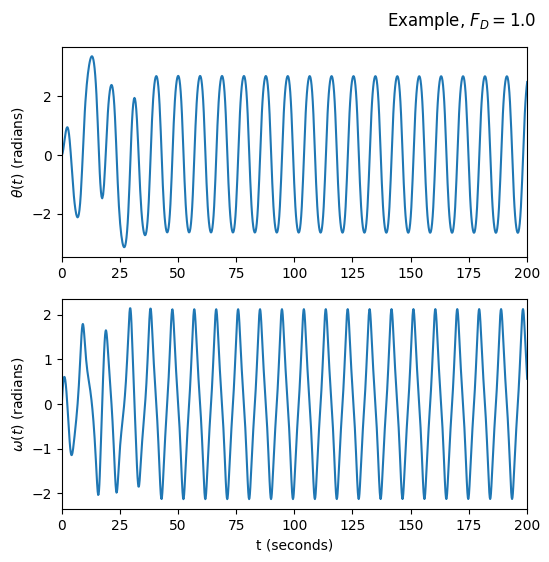

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(example_t, example_theta)
ax[0].set_ylabel(r"$\theta(t)$ (radians)")
ax[0].text(0.7, 1.1, fr"Example, $F_D={example_pendulum.F_D}$", size="large", transform=ax[0].transAxes)
ax[0].set_xlim(0., 200.)

ax[1].plot(example_t, example_omega)
ax[1].set_xlabel("t (seconds)")
ax[1].set_ylabel(r"$\omega(t)$ (radians)")
ax[1].set_xlim(0., 200.)

## Your turn

Write your code for the problem here. You will probably need a lot of the code from CompPhys/ODEs/pendulum_nonlinear.ipynb!

In [45]:
# Note: this is a good use case for multiprocessing. Here is an example using ProcessPoolExecutor. 
# (For CPU-bound problems, use process-based parallelism. For I/O-bound problems, use thread-based parallelism instead.)
def some_func(x):
    # Dummy function
    time.sleep(1)
    return x, np.ones(10) * x

print("Test one call")
t1 = time.time()
some_func(0.)
t2 = time.time()
print(f"One call, T = {t2-t1} s")

print(f"cpu_count = {os.cpu_count()}")
nworkers = os.cpu_count() # or os.cpu_count()
with concurrent.futures.ProcessPoolExecutor(max_workers=nworkers) as executor:
    xlist = np.arange(0, 3*os.cpu_count(), 1)
    results = {}
    t1 = time.time()
    for x, result in executor.map(some_func, xlist):
        results[x] = result
    t2 = time.time()
    print(f"{len(xlist)} calls with {nworkers} workers: T = {t2-t1} s")
pprint(results)

Test one call
One call, T = 1.0041708946228027 s
cpu_count = 8
24 calls with 8 workers: T = 3.048189640045166 s
{np.int64(0): array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.int64(1): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 np.int64(2): array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
 np.int64(3): array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]),
 np.int64(4): array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]),
 np.int64(5): array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
 np.int64(6): array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6.]),
 np.int64(7): array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 np.int64(8): array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]),
 np.int64(9): array([9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]),
 np.int64(10): array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 np.int64(11): array([11., 11., 11., 11., 11., 11., 11., 11., 11., 11.]),
 np.int64(12): array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12.]),
 np.int64(13): array([13., 13., 13.,